In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [4]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [5]:
flu.columns

Index(['valueCategory', 'temporal', 'temporal_type', 'georegion',
       'georegion_type', 'agegroup', 'agegroup_type', 'sex', 'value',
       'popExtrapolation', 'totalConsultationsExtrapolation', 'incValue',
       'prctConsultations', 'prct', 'trend', 'dataComplete'],
      dtype='object')

In [6]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue', 'value']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [7]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [8]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [9]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [10]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [11]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [12]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'value', 'region_x',
       'date', 'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [13]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [14]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [15]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [16]:
# merged_data.set_index('date', inplace=True)

In [17]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

In [18]:
merged_data

,temporal,georegion,flu_cases,incValue,value,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,...,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,week_number,year,date
0,2013-W01,region_1,16876.1,53.33,918.5,3.044123,82.918337,6.597668,-1.041057,95.043840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,2013-01-03
1,2013-W02,region_1,33045.6,114.99,1980.4,1.899121,85.732108,4.005557,-0.232400,94.972297,...,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910,2,2013,2013-01-10
2,2013-W03,region_1,37204.9,185.46,3194.0,-1.508554,77.031993,0.870462,-4.233867,90.875307,...,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839,3,2013,2013-01-17
3,2013-W04,region_1,36421.1,307.51,5296.0,-0.759157,77.826791,2.469204,-4.891194,90.988158,...,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188,4,2013,2013-01-24
4,2013-W05,region_1,39004.7,502.50,8654.2,4.551592,78.802057,7.993836,0.627968,92.950733,...,-6.717551,3.014675,7.500430,11.163364,-1.808321,-1.522283,14.493968,5,2013,2013-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,270.0,8.779691,86.279860,112.068950,15.165819,16.738540,...,7.342648,-4.320877,11.786683,0.000000,-0.022954,-0.426565,0.449520,42,2023,2023-10-19
3404,2023-W43,region_6,13789.4,116.03,642.3,8.713151,90.941844,146.785800,14.580323,16.035777,...,-0.478980,-5.410189,11.814702,0.000000,-0.171670,-0.269120,0.440791,43,2023,2023-10-26
3405,2023-W44,region_6,9232.8,54.15,299.8,5.359404,93.029671,113.603722,11.504548,19.159654,...,0.224958,-6.142114,11.842689,41.462083,41.346561,-0.316517,0.432039,44,2023,2023-11-02
3406,2023-W45,region_6,13692.8,131.46,727.7,3.145168,86.804555,210.945316,10.245397,16.910679,...,-0.333561,1.301569,11.870648,0.000000,-0.190492,-0.232774,0.423265,45,2023,2023-11-09


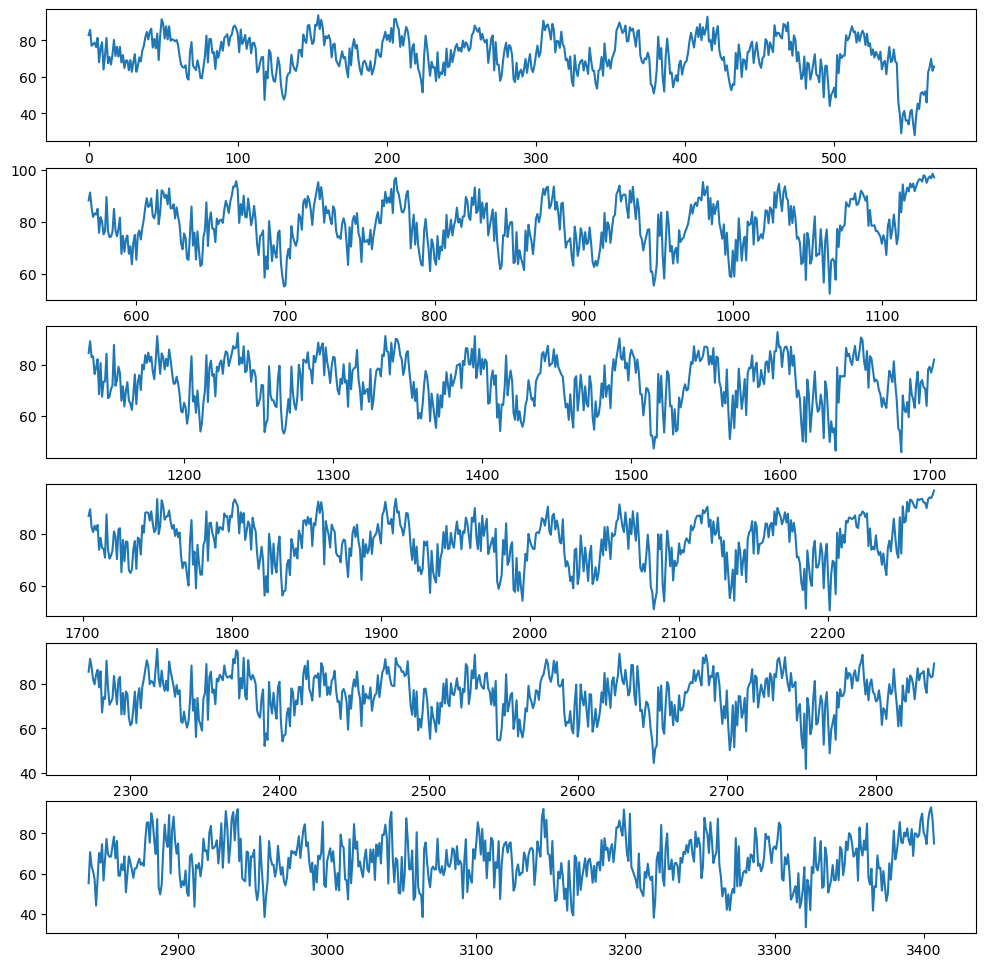

In [19]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'weighted_avg_daily_hum'])

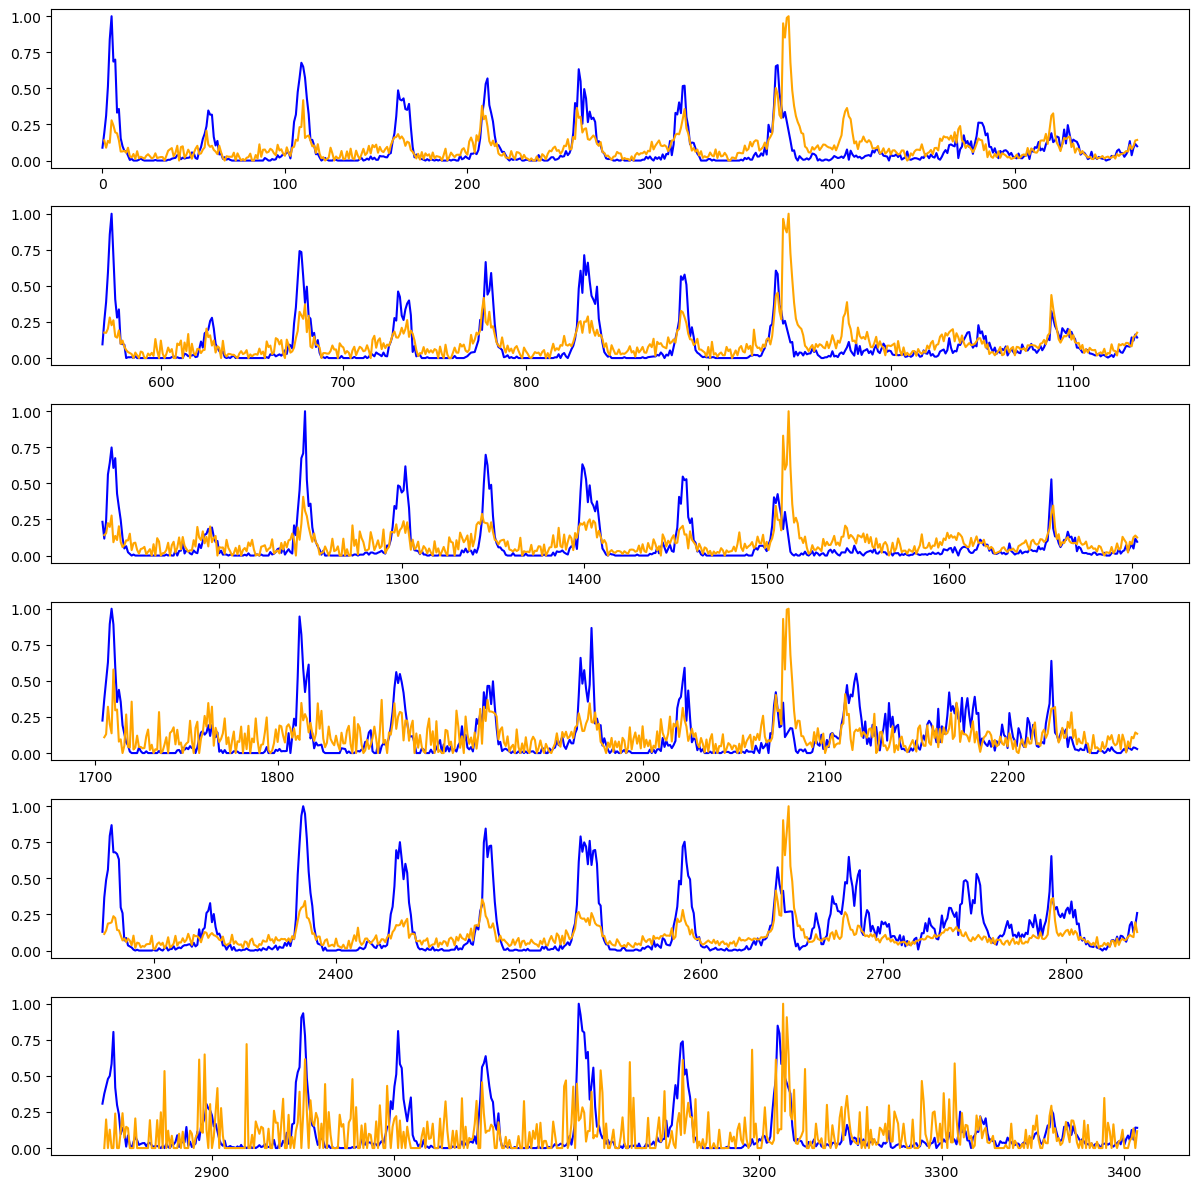

In [20]:
# fig, ax = plt.subplots(6, figsize=(12, 12))
# for i in range(1, 7):
#     ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])
#     ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'Grippe'])

import matplotlib.pyplot as plt

# Assuming merged_data is your DataFrame and it's already been imported.

fig, ax = plt.subplots(6, figsize=(12, 12))

for i in range(1, 7):
    # Filter the data for the current region
    region_data = merged_data[merged_data['georegion'] == f"region_{i}"]
    
    # Find the maximum values for 'incValue' and 'Grippe' in the current region
    max_incValue_region = region_data['incValue'].max()
    max_Grippe_region = region_data['Grippe'].max()
    
    # Determine the scale factors
    scale_factor_incValue = 1.0 / max_incValue_region if max_incValue_region != 0 else 1
    scale_factor_Grippe = 1.0 / max_Grippe_region if max_Grippe_region != 0 else 1
    
    # Apply the scale factors to normalize the amplitude
    normalized_incValue = region_data['incValue'] * scale_factor_incValue
    normalized_Grippe = region_data['Grippe'] * scale_factor_Grippe
    
    # Plot the normalized data
    ax[i-1].plot(normalized_incValue, color='blue')
    ax[i-1].plot(normalized_Grippe, color='orange')
    
plt.tight_layout()
plt.show()



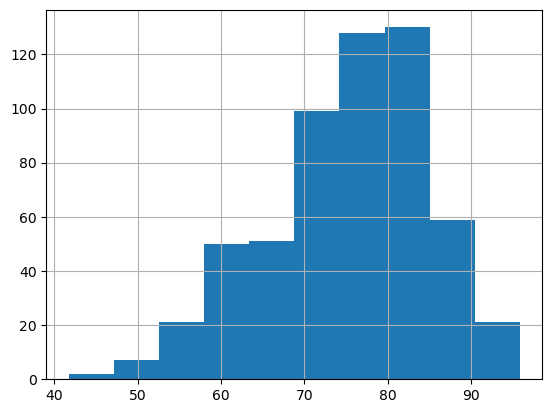

In [21]:
from matplotlib import pyplot
merged_data.loc[merged_data['georegion'] == "region_5", 'weighted_avg_daily_hum'].hist()
pyplot.show()

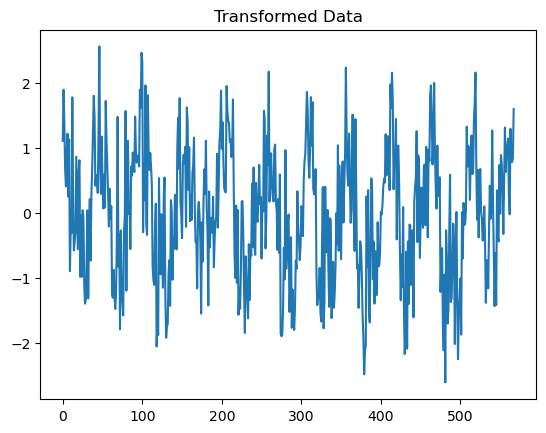

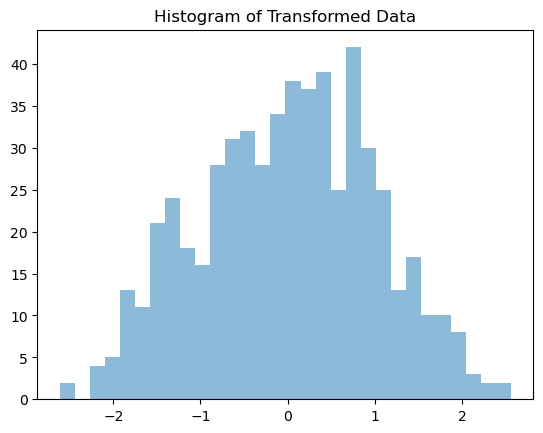

In [22]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming you have imported your dataset and stored it in merged_data

# Create the PowerTransformer with 'yeo-johnson' method
boxcox_transformer = PowerTransformer(method='yeo-johnson')

# Filter and select the data based on the 'georegion' condition and 'incValue' column
filtered_data = merged_data.loc[merged_data['georegion'] == "region_5", 'weighted_avg_daily_hum']

# Fit and transform the filtered data
transformed_data = boxcox_transformer.fit_transform(filtered_data.values.reshape(-1, 1))

# Create a figure and axis for the transformed data
fig1, ax1 = plt.subplots()
ax1.plot(transformed_data)
ax1.set_title('Transformed Data')

# Create a figure and axis for the histogram of transformed data
fig2, ax2 = plt.subplots()
ax2.hist(transformed_data, bins=30, alpha=0.5)
ax2.set_title('Histogram of Transformed Data')

# Show the plots
plt.show()


<h3>Modelling</h3>

In [23]:
def create_lagged_features(df, column, number_of_lags, seasonal_lags=None):
    # Copy the original DataFrame to avoid modifying it
    df_lagged = df.copy()

    # Generate regular lagged features
    for lag in range(1, number_of_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged[column].shift(lag)

    # Generate seasonal lags
    if seasonal_lags is not None:
        for season_lag in seasonal_lags:
            df_lagged[f'seasonal_lag_{season_lag}_helper'] = df_lagged[column].shift(season_lag-1)
            df_lagged[f'seasonal_lag_{season_lag}'] = df_lagged[column].shift(season_lag)

    return df_lagged


In [24]:
import pandas as pd

def create_lagged_features(df, column_lags, seasonal_lags=None):
    """
    Create lagged features for multiple columns in a DataFrame, with a specified number of lags for each column.

    Parameters:
    df (DataFrame): The original DataFrame.
    columns_with_lags (dict): A dictionary mapping column names to the number of lags. e.g., {'column1': 3, 'column2': 5}
    seasonal_lags (list of int, optional): Additional seasonal lags to include.

    Returns:
    DataFrame: A DataFrame containing the original columns and their lagged features.
    """

    df_lagged = df.copy()
    seasonal_lags = seasonal_lags or []

    for column, num_lags in column_lags.items():
        # Create specified number of lagged features for each column
        for lag in range(1, num_lags + 1):
            df_lagged[f'{column}_lag_{lag}'] = df_lagged[column].shift(lag)

        # Create seasonal lagged features if specified
        for seasonal_lag in seasonal_lags:
            df_lagged[f'{column}_seasonal_lag_{seasonal_lag}_helper'] = df_lagged[column].shift(seasonal_lag-1)
            df_lagged[f'{column}_seasonal_lag_{seasonal_lag}'] = df_lagged[column].shift(seasonal_lag)

    # Drop rows with NaN values created by lagging
    df_lagged.dropna(inplace=True)

    return df_lagged


column_lags = {
    'incValue': 10,
    'Grippe': 5
    }

df_lagged = create_lagged_features(merged_data[['incValue', 'Grippe']], column_lags=column_lags, seasonal_lags=[52])

In [26]:
df_lagged

,incValue,Grippe,incValue_lag_1,incValue_lag_2,incValue_lag_3,incValue_lag_4,incValue_lag_5,incValue_lag_6,incValue_lag_7,incValue_lag_8,...,incValue_lag_10,incValue_seasonal_lag_52_helper,incValue_seasonal_lag_52,Grippe_lag_1,Grippe_lag_2,Grippe_lag_3,Grippe_lag_4,Grippe_lag_5,Grippe_seasonal_lag_52_helper,Grippe_seasonal_lag_52
53,37.79,4.307718,6.67,10.29,31.21,33.72,13.46,11.51,10.90,8.23,...,5.46,185.46,114.99,9.770956,7.815605,4.718351,1.211708,4.865348,8.495091,13.364971
54,55.35,4.727086,37.79,6.67,10.29,31.21,33.72,13.46,11.51,10.90,...,11.95,307.51,185.46,4.307718,9.770956,7.815605,4.718351,1.211708,13.066783,8.495091
55,89.60,7.208386,55.35,37.79,6.67,10.29,31.21,33.72,13.46,11.51,...,8.23,502.50,307.51,4.727086,4.307718,9.770956,7.815605,4.718351,11.777776,13.066783
56,110.63,8.708749,89.60,55.35,37.79,6.67,10.29,31.21,33.72,13.46,...,10.90,598.30,502.50,7.208386,4.727086,4.307718,9.770956,7.815605,26.653876,11.777776
57,142.13,19.740332,110.63,89.60,55.35,37.79,6.67,10.29,31.21,33.72,...,11.51,410.24,598.30,8.708749,7.208386,4.727086,4.307718,9.770956,23.306998,26.653876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,48.78,4.557310,80.60,57.94,21.90,81.52,24.07,43.65,32.31,22.49,...,16.36,99.59,90.14,0.000000,0.000000,0.000000,11.287922,4.959426,20.108813,11.292177
3404,116.03,6.165772,48.78,80.60,57.94,21.90,81.52,24.07,43.65,32.31,...,9.26,76.21,99.59,4.557310,0.000000,0.000000,0.000000,11.287922,5.052576,20.108813
3405,54.15,12.063468,116.03,48.78,80.60,57.94,21.90,81.52,24.07,43.65,...,22.49,34.39,76.21,6.165772,4.557310,0.000000,0.000000,0.000000,0.000000,5.052576
3406,131.46,0.000000,54.15,116.03,48.78,80.60,57.94,21.90,81.52,24.07,...,32.31,25.62,34.39,12.063468,6.165772,4.557310,0.000000,0.000000,0.000000,0.000000


In [ ]:
import numpy as np

def autoregressive_iterative_forecast(model, initial_input, seasonal_input, exogenous_forecasts, n_steps):
    """
    Perform iterative forecasting using an autoregressive model with multiple exogenous variable forecasts.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features (e.g., the last observation from the training set).
        seasonal_input: Seasonal input features for the autoregressive model.
        exogenous_forecasts: List of arrays, each containing forecasted values for an exogenous variable.
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    i = 0
    current_input = np.array(initial_input.copy())
    seasonal_input = np.array(seasonal_input)
    forecasts = []

    for _ in range(n_steps):
        # Predict the next step
        next_step_pred = model.predict(current_input.reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update the current input to include the new prediction
        # Find the index where exogenous variables start
        exog_start_index = len(current_input) - len(seasonal_input) - sum(len(exog_forecast) for exog_forecast in exogenous_forecasts)
        
        # Roll all autoregressive lags
        current_input[:exog_start_index] = np.roll(current_input[:exog_start_index], 1)
        current_input[0] = next_step_pred
        
        # Update the seasonal lag (if applicable)
        seasonal_lag_index = exog_start_index + len(seasonal_input)
        if seasonal_input.size > 0:
            if i < len(seasonal_input):
                current_input[exog_start_index:seasonal_lag_index] = seasonal_input[i]
            else:
                current_input[exog_start_index:seasonal_lag_index] = forecasts[i - len(seasonal_input)]

        # Update the input with the forecasted exogenous variable values
        for j, exog_forecast in enumerate(exogenous_forecasts):
            current_input[seasonal_lag_index + j] = exog_forecast[i]

        i += 1

    return np.array(forecasts)


In [25]:
import numpy as np

def iterative_forecast(model, initial_input, seasonal_input,  n_steps, exogenous_forecasts=None):
    """
    Perform iterative forecasting using an autoregressive model with optional exogenous variable forecasts.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features for the target variable (e.g., the last observation from the training set).
        seasonal_input: Seasonal input features for the target variable.
        exogenous_forecasts: (Optional) List or array containing the forecasted values for the exogenous variable(s) for each future time step.
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    forecasts = []
    current_input = np.array(initial_input)
    seasonal_input = np.array(seasonal_input)

    # Check if exogenous forecasts are provided
    if exogenous_forecasts is None:
        exogenous_forecasts = np.empty((n_steps, 0))  # Empty array with 0 columns

    for i in range(n_steps):
        # Prepare the input array for prediction
        combined_input = np.concatenate([
            current_input,
            exogenous_forecasts[i] if exogenous_forecasts.shape[1] > 0 else []  # Add the forecasted exogenous values if provided
        ])
        
        # Predict the next step
        next_step_pred = model.predict(combined_input.reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update the autoregressive lags for the target variable
        current_input = np.roll(current_input, 1)
        current_input[0] = next_step_pred
        
        # Update the seasonal lag, if applicable
        if i < 52:
            current_input[-1] = seasonal_input[i]
        else:
            current_input[-1] = forecasts[i - 52]

    return np.array(forecasts)


# # training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
# # X_train_cv_scaled = df_lagged[training_cols]
# # print(X_train_cv_scaled.iloc[0], f'Length:{len(X_train_cv_scaled.iloc[0])}')
# # print(df_lagged['seasonal_lag_52_helper'].iloc[:52])
# # prediction = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], df_lagged[['seasonal_lag_52_helper']], 53)

In [ ]:
def create_exogenous_input(model, initial_input, seasonal_input, n_steps):
    """
    Create a 2D array for exogenous variable inputs for each forecast step.

    Args:
        model: Model for exogenous variable to predict one week ahead.
        initial_input (array-like): The initial lag values for the exogenous variable.
        seasonal_input (array-like): Array of the values one week before the seasonal column for updating (essentially the lag_51 column, named 'seasonal_helper' in this notebook).
        n_steps (int): Number of future time steps to forecast.

    Returns:
        numpy.ndarray: A 2D array where each row represents all the lags and the seasonal lag for the exogenous variable for each week.
    """
    num_lags = len(initial_input)
    
    initial_input = np.array(initial_input)
    seasonal_input = np.array(seasonal_input)
    
    output_array = np.zeros((n_steps, num_lags))

    # Set initial lags and seasonal lag
    output_array[0, :] = initial_input

    forecasts = []
    for i in range(1, n_steps):
        # Predict the next step
        next_step_pred = model.predict(output_array[i-1,:].reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update lags: shift left and add new forecast
        output_array[i, :-1] = np.roll(output_array[i-1, :-1], 1) # Roll the consecutive autoregressive lags from one row before to shift weeks
        output_array[i, 0] = forecasts[i-1]  # Insert most recent forecast in first position

        # Update seasonal lag
        if i < 52:
            output_array[i, -1] = seasonal_input[i-1]
        else:
            output_array[i, -1] = output_array[i-52, 0] # Fill in using the forecast from 52 weeks ago

    return output_array[1:, :] # Don't return the first column where value are all known to avoid shift

In [26]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress convergence warnings
# warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Define parameter configurations to assess
lags = 52 # Autoregressive lags to consider
hidden_layer_sizes = [(16, 16), (32,)]
alphas = [0.01, 0.1, 0.2] # Regularization parameter
batch_size = 32
learning_rates = [0.0001]
activations = ['relu']
seasonal = [52]

models_count = (lags-26)* len(hidden_layer_sizes) * len(alphas) * len(learning_rates) * len(activations)

# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']
grippe = data['incValue']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]
grippe_train, grippe_test = grippe[:split], grippe[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])

# Grid search hyperparameter configurations
for lag in range(20, lags-6):
    for activation in activations:
        for learning_rate in learning_rates:
            for alpha in alphas:
                for hidden_layer_size in hidden_layer_sizes:
                    # Keep track of configurations and cv scores
                    model = MLPRegressor(max_iter=1000, 
                                        random_state=42, 
                                        solver='adam', 
                                        activation=activation, 
                                        hidden_layer_sizes=hidden_layer_size, 
                                        alpha=alpha, 
                                        batch_size=batch_size, 
                                        learning_rate_init=learning_rate,
                                        warm_start=False, 
                                        early_stopping=True)

                    grippe_model = MLPRegressor(max_iter=1000, 
                                        random_state=42, 
                                        solver='adam', 
                                        activation='relu', 
                                        hidden_layer_sizes=(16, 16), 
                                        alpha=0.2, 
                                        batch_size=32, 
                                        learning_rate_init=0.0001)

                    scores = []
                    tscv = TimeSeriesSplit(n_splits=3, test_size=52) # Initiate three-fold expanding window CV with validation window size of 52 weeks
                    fold = 0 # Counter for folds (used for plotting)

                    # Define number of lags to create in the training set (exogenous variables config cross-validated separately)
                    column_lags = {
                        'incValue': {lag},
                        'Grippe': 25
                        }

                    # Create lagged features based on the whole available training data
                    df_lagged = create_lagged_features(pd.DataFrame([y_train, grippe_train], columns=['incValue', 'Grippe']), column_lags=column_lags, seasonal_lags=[52])
                    
                    df_lagged.dropna(inplace=True)
                    
                    
                    # Assign columns for preprocessing and training of autoregressive component
                    flu_training_cols = [col for col in df_lagged.columns if ('incValue_lag' in col) and ('_helper' not in col)] # Select cols to include as features
                    flu_seasonal_col = [col for col in df_lagged.columns if ('incValue' in col) and ('_helper' in col)] # Select cols to include as features
                    X = df_lagged[flu_training_cols]
                    X_seasonal = df_lagged[flu_seasonal_col]
                    y = df_lagged['incValue']

                    # Assign columns for preprocessing and training of exogenous component
                    grippe_training_cols = [col for col in df_lagged.columns if ('Grippe_lag' in col) and ('_helper' not in col)] # Select cols to include as features
                    grippe_seasonal_col = [col for col in df_lagged.columns if ('Grippe' in col) and ('_helper' in col)] # Select cols to include as features
                    grippe = df_lagged[grippe_training_cols]
                    grippe_seasonal = df_lagged[grippe_seasonal_col]
                    grippe_y = df_lagged['Grippe']
                    
                    for train_index, val_index in tscv.split(X):
                        
                        ############################################################################################################################################
                        # TRANSFORMATION AND SCALING OF AUTOREGRESSIVE LAGS
                        y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
                        X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
                        X_seasonal_train, X_seasonal_val = X_seasonal.iloc[train_index], X_seasonal.iloc[val_index]

                        # Take the first row of X_train_cv (the oldest lags)
                        oldest_lags = X_train_cv.iloc[0, 1:].values.reshape(1, -1)

                        # Concatenate y_train_cv with the oldest lags
                        combined_data = np.vstack((y_train_cv.values.reshape(-1, 1), oldest_lags.T))

                        # Fit the PowerTransformer and StandardScaler on the available lags in the training data (incl. lags in first row of lag df_train)
                        pt = PowerTransformer(method='yeo-johnson')
                        stdscaler = StandardScaler()
                        combined_data_transformed = pt.fit_transform(combined_data)
                        stdscaler.fit(combined_data_transformed)
                        
                        # Apply Transform to the entire y_train_cv
                        y_train_cv_transformed = pt.transform(y_train_cv.values.reshape(-1, 1)).flatten()
                        y_val_transformed = pt.transform(y_val.values.reshape(-1, 1)).flatten()

                        # Apply the PowerTransformer to each lagged feature in X_train_cv and X_val
                        X_train_cv_transformed = X_train_cv.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
                        X_val_transformed = X_val.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
                        X_seasonal_train_trans = pt.transform(X_seasonal_train.values.reshape(-1, 1)).flatten()
                        X_seasonal_val_trans = pt.transform(X_seasonal_val.values.reshape(-1, 1)).flatten()

                        
                        # Apply StandardScaler()
                        y_train_cv_scaled = stdscaler.transform(y_train_cv_transformed.reshape(-1, 1)).flatten()
                        y_val_scaled = stdscaler.transform(y_val_transformed.reshape(-1, 1)).flatten()
                        X_train_cv_scaled = X_train_cv_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        X_val_scaled = X_val_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        X_seasonal_train_scaled = stdscaler.transform(X_seasonal_train_trans.reshape(-1, 1)).flatten()
                        X_seasonal_val_scaled = stdscaler.transform(X_seasonal_val_trans.reshape(-1, 1)).flatten()

                        ############################################################################################################################################
                        # Scale Google Data
                        grippe_y_train_cv, grippe_y_val = grippe_y.iloc[train_index], grippe_y.iloc[val_index]
                        grippe_train_cv, grippe_val = grippe.iloc[train_index], grippe.iloc[val_index]
                        grippe_seasonal_train, grippe_seasonal_val = grippe_seasonal.iloc[train_index], grippe_seasonal.iloc[val_index]
                        # Take the first row of X_train_cv (the oldest lags)
                        oldest_grippe_lags = grippe_train_cv.iloc[0, 1:].values.reshape(1, -1)

                        # Concatenate grippe_y_train_cv with the oldest lags
                        grippe_combined_data = np.vstack((grippe_y_train_cv.values.reshape(-1, 1), oldest_grippe_lags.T))

                        # Fit the PowerTransformer and StandardScaler on the available lags in the training data (incl. lags in first row of lag df_train)
                        grippe_pt = PowerTransformer(method='yeo-johnson')
                        grippe_stdscaler = StandardScaler()
                        grippe_combined_data_transformed = pt.fit_transform(combined_data)
                        grippe_stdscaler.fit(combined_data_transformed)

                        # Apply Transform to the entire y_train_cv
                        grippe_y_train_cv_transformed = pt.transform(grippe_y_train_cv.values.reshape(-1, 1)).flatten()
                        grippe_y_val_transformed = pt.transform(grippe_y_val.values.reshape(-1, 1)).flatten()

                        # Apply the PowerTransformer to each lagged feature in X_train_cv and X_val
                        grippe_train_cv_transformed = grippe_train_cv.apply(lambda column: grippe_pt.transform(column.values.reshape(-1, 1)).flatten())
                        grippe_val_transformed = grippe_val.apply(lambda column: grippe_pt.transform(column.values.reshape(-1, 1)).flatten())
                        grippe_seasonal_train_trans = grippe_pt.transform(grippe_seasonal_train.values.reshape(-1, 1)).flatten()
                        grippe_seasonal_val_trans = grippe_pt.transform(grippe_seasonal_val.values.reshape(-1, 1)).flatten()

                        
                        # Apply StandardScaler()
                        grippe_y_train_cv_scaled = grippe_stdscaler.transform(grippe_y_train_cv_transformed.reshape(-1, 1)).flatten()
                        grippe_y_val_scaled = grippe_stdscaler.transform(grippe_y_val_transformed.reshape(-1, 1)).flatten()
                        grippe_train_cv_scaled = grippe_train_cv_transformed.apply(lambda column: grippe_stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        grippe_val_scaled = grippe_val_transformed.apply(lambda column: grippe_stdscaler.transform(column.values.reshape(-1, 1)).flatten())
                        grippe_seasonal_train_scaled = grippe_stdscaler.transform(grippe_seasonal_train_trans.reshape(-1, 1)).flatten()
                        grippe_seasonal_val_scaled = grippe_stdscaler.transform(grippe_seasonal_val_trans.reshape(-1, 1)).flatten()

                        grippe_model.fit(grippe_train_cv_scaled, grippe_train_cv_scaled)

                        grippe_input = create_exogenous_input(model=grippe_model, initial_input=grippe_val_scaled.iloc[0], seasonal_input=grippe_seasonal_val_scaled, n_steps=len(grippe_y_val_scaled))
                        grippe_input_on_test = create_exogenous_input(model=grippe_model, initial_input=grippe_train_cv_scaled.iloc[0], seasonal_input=grippe_seasonal_train_scaled, n_steps=len(grippe_y_train_cv_scaled))

                        ############################################################################################################################################
                        # NOTE: PLOT VALIDATION AND TRAINING LOSSES - Adjust max_iter to 1 and set warm_start = True to enable

                        # training_losses = []
                        # validation_losses = []

                        # for epoch in range(1000):  # Adjust the number of epochs as needed
                        #     model.fit(X_train_cv_scaled.values, y_train_cv_scaled)

                        #     # Store training loss from the last iteration
                        #     training_losses.append(model.loss_curve_[-1])

                        #     # Compute and store validation loss
                        #     val_predictions = model.predict(X_val_scaled.values)
                        #     val_loss = mean_squared_error(y_val_scaled, val_predictions)
                        #     validation_losses.append(val_loss)
                        
                        # if fold == 2:
                        #     plt.plot(training_losses, label='Training Loss')
                        #     # If you have validation loss, plot it here
                        #     plt.plot(validation_losses, label='Validation Loss')

                        #     plt.title('Learning Curve')
                        #     plt.xlabel('Epochs')
                        #     plt.ylabel('Loss')
                        #     plt.title(f'Lags: {lag}, Learning-rate: {learning_rate}, alpha: {alpha}, hidden layers: {hidden_layer_size}')
                        #     plt.legend()
                        #     plt.show()

                        #######################

                        # Fit model
                        model.fit(np.concatenate(X_train_cv_scaled.values, grippe_train_cv_scaled.valules, axis=1), y_train_cv_scaled)
                        
                        # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
                        prediction = iterative_forecast(model=model, initial_input=X_val_scaled.iloc[0], seasonal_input=X_seasonal_val_scaled, exogenous_forecasts=grippe_input, n_steps=len(y_val_scaled))
                        y_hat_train = iterative_forecast(model=model, initial_input=X_train_cv_scaled.iloc[0], seasonal_input=X_seasonal_train_scaled, exogenous_forecasts=grippe_input, n_steps=len(y_train_cv_scaled))
                        prediction = np.array(prediction).flatten()
                        y_hat_train = np.array(y_hat_train).flatten()

                        #######################
                        # NOTE: UNCOMMENT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
                        # plt.figure(figsize=(10, 6))
                        # plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
                        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
                        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
                        # plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
                        
                        # plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
                        # plt.xlabel('Time')
                        # plt.ylabel('Scaled Value')
                        # plt.legend()
                        # plt.show()
                        ########################

                        rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

                        scores.append(rmse)
                        fold += 1
                    
                    # Fill in parameters and score for each configuration 
                    scores_df.loc[i, 'lags'] = lag
                    scores_df.loc[i, 'seasonal_lags'] = seasonal
                    scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
                    scores_df.loc[i, 'alpha'] = alpha
                    scores_df.loc[i, 'batch_size'] = batch_size
                    scores_df.loc[i, 'activation'] = activation
                    scores_df.loc[i, 'learning_rate'] = learning_rate
                    scores_df.loc[i, 'RMSE'] = np.mean(scores)
                    print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
                    i += 1

0/156: 0.00%
1/156: 0.64%
2/156: 1.28%
3/156: 1.92%
4/156: 2.56%
5/156: 3.21%
6/156: 3.85%
7/156: 4.49%
8/156: 5.13%
9/156: 5.77%
10/156: 6.41%
11/156: 7.05%
12/156: 7.69%
13/156: 8.33%
14/156: 8.97%
15/156: 9.62%
16/156: 10.26%
17/156: 10.90%
18/156: 11.54%
19/156: 12.18%
20/156: 12.82%
21/156: 13.46%
22/156: 14.10%
23/156: 14.74%
24/156: 15.38%
25/156: 16.03%
26/156: 16.67%
27/156: 17.31%
28/156: 17.95%
29/156: 18.59%
30/156: 19.23%
31/156: 19.87%
32/156: 20.51%
33/156: 21.15%
34/156: 21.79%
35/156: 22.44%
36/156: 23.08%
37/156: 23.72%
38/156: 24.36%
39/156: 25.00%
40/156: 25.64%
41/156: 26.28%
42/156: 26.92%
43/156: 27.56%
44/156: 28.21%
45/156: 28.85%
46/156: 29.49%
47/156: 30.13%
48/156: 30.77%
49/156: 31.41%
50/156: 32.05%
51/156: 32.69%
52/156: 33.33%
53/156: 33.97%
54/156: 34.62%
55/156: 35.26%
56/156: 35.90%
57/156: 36.54%
58/156: 37.18%
59/156: 37.82%
60/156: 38.46%
61/156: 39.10%
62/156: 39.74%
63/156: 40.38%
64/156: 41.03%
65/156: 41.67%
66/156: 42.31%
67/156: 42.95%
68/156

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


144/156: 92.31%
145/156: 92.95%


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


146/156: 93.59%
147/156: 94.23%


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


148/156: 94.87%
149/156: 95.51%
150/156: 96.15%
151/156: 96.79%
152/156: 97.44%
153/156: 98.08%
154/156: 98.72%
155/156: 99.36%


In [28]:
scores_df['RMSE'] = pd.to_numeric(scores_df['RMSE'])
# Best parameters and score
best_config_index = scores_df['RMSE'].idxmin()  # This gets the index of the minimum RMSE
best_config = scores_df.loc[best_config_index]  # Use the index to access the row
best_score = best_config['RMSE']
print(f"Best parameters: {best_config}")
print(f"Best score (RMSE): {best_score}")

Best parameters: RMSE             0.760004
lags                   25
seasonal_lags        [52]
hidden_layers    (16, 16)
alpha                 0.2
batch_size             32
activation           relu
learning_rate      0.0001
Name: 34, dtype: object
Best score (RMSE): 0.7600036598458831


In [29]:
scores_df.sort_values(by='RMSE').head(20)

,RMSE,lags,seasonal_lags,hidden_layers,alpha,batch_size,activation,learning_rate
34,0.760004,25,[52],"(16, 16)",0.2,32,relu,0.0001
32,0.763214,25,[52],"(16, 16)",0.1,32,relu,0.0001
30,0.770624,25,[52],"(16, 16)",0.01,32,relu,0.0001
68,0.789401,31,[52],"(16, 16)",0.1,32,relu,0.0001
66,0.789421,31,[52],"(16, 16)",0.01,32,relu,0.0001
70,0.794368,31,[52],"(16, 16)",0.2,32,relu,0.0001
64,0.804587,30,[52],"(16, 16)",0.2,32,relu,0.0001
62,0.808277,30,[52],"(16, 16)",0.1,32,relu,0.0001
60,0.809465,30,[52],"(16, 16)",0.01,32,relu,0.0001
42,0.832987,27,[52],"(16, 16)",0.01,32,relu,0.0001


In [55]:
best_config = scores_df.loc[34]

In [56]:
best_lag = best_config.values[1]
best_seasonal_lag = best_config.values[2]
best_hidden_layers = best_config.values[3]
best_alpha = best_config.values[4]
best_batch_size = best_config.values[5]
best_activation = best_config.values[6]
best_learning_rate = best_config.values[7]

In [57]:
best_learning_rate

0.0001

In [58]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['Grippe']

# Create lagged features based on the whole y
df_lagged = create_lagged_features(pd.DataFrame(y, columns=['Grippe']), column='Grippe', number_of_lags=best_lag, seasonal_lags=best_seasonal_lag)

split = int(len(y) * 0.8)
# NOTE: SPLIT BEFORE DROPPING TO AVOID DATA LEAKAGE
df_lagged_train = df_lagged.iloc[:split]
df_lagged_train = df_lagged_train.dropna()
df_lagged_test = df_lagged.iloc[split:]

# Extract training columns and output variable from dataframe
training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('helper' not in col)]
X_train = df_lagged_train[training_cols]
y_train = df_lagged_train['Grippe']
X_test = df_lagged_test[training_cols]
y_test = df_lagged_test['Grippe']

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
X_train_seasonal = df_lagged_train['seasonal_lag_52_helper']
X_test_seasonal = df_lagged_test['seasonal_lag_52_helper']

# Create combined data to fit transform on all available historical lags in training set
oldest_lags = X_train.iloc[0, 1:].values.reshape(1, -1) # Take the first row of X_train_cv (the oldest lags)
combined_data = np.vstack((y_train.values.reshape(-1, 1), oldest_lags.T)) # Concatenate y_train_cv with the oldest lags

# Fit Yeo-Johnson Transform on combined data
pt = PowerTransformer(method='yeo-johnson')
stdscaler = StandardScaler()
combined_data_transformed = pt.fit_transform(combined_data)
stdscaler.fit(combined_data_transformed)

# Apply transform and scaling to train and test sets
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
X_train_transformed = X_train.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
# X_train_transformed = X_train.apply(lambda x: pt.transform(x))
# X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1))).flatten()
X_train_seasonal_trans = pt.transform(X_train_seasonal.values.reshape(-1, 1)).flatten()
X_test_seasonal_trans = pt.transform(X_test_seasonal.values.reshape(-1, 1)).flatten()

# Apply StandardScaler
y_train_scaled = stdscaler.transform(y_train_transformed.reshape(-1, 1)).flatten()
y_test_scaled = stdscaler.transform(y_test_transformed.reshape(-1, 1)).flatten()
X_train_scaled = X_train_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_test_scaled = X_test_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_train_seasonal_scaled = stdscaler.transform(X_train_seasonal_trans.reshape(-1, 1)).flatten()
X_test_seasonal_scaled = stdscaler.transform(X_test_seasonal_trans.reshape(-1, 1)).flatten()

# Initialize the final model configuration
final_model = MLPRegressor(max_iter=1000, 
                    random_state=42, 
                    solver='adam', 
                    activation=best_activation, 
                    hidden_layer_sizes=(best_hidden_layers), 
                    alpha=best_alpha, 
                    batch_size=best_batch_size, 
                    learning_rate_init=best_learning_rate)

# Train final model
final_model.fit(X_train_scaled.values, y_train_scaled) 

# Forecast for the length of the test set
forecasts = autoregressive_iterative_forecast(final_model, X_test_scaled.iloc[0], X_test_seasonal_scaled,len(y_test_scaled))
y_hat_train = autoregressive_iterative_forecast(final_model, X_train_scaled.iloc[0], X_train_seasonal_scaled, len(y_train))

forecasts = stdscaler.inverse_transform(forecasts.reshape(-1, 1))
forecasts = pt.inverse_transform(forecasts.reshape(-1, 1))
y_hat_train = stdscaler.inverse_transform(y_hat_train.reshape(-1, 1))
y_hat_train = pt.inverse_transform(y_hat_train.reshape(-1, 1))

# Evaluate the forecasts against the actual y_test values
rmse = mean_squared_error(y_test, forecasts, squared=False)

print(f"The RMSE for the forecasts is: {rmse:.3f}")

The RMSE for the forecasts is: 4.129


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


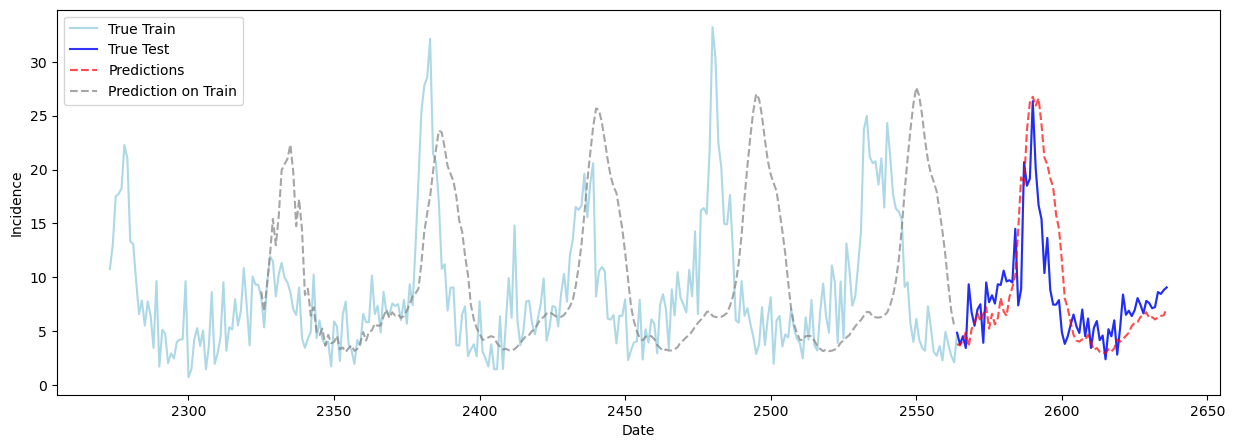

In [59]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the true values
# ax.plot(plot['Grippe'])

ax.plot(df_lagged['Grippe'], label="True Train", alpha=1, color='lightblue')
ax.plot(y_test.index, y_test, label="True Test", alpha=0.8, color='blue')
ax.plot(y_test.index, forecasts, label='Predictions', alpha=0.7, color='red', linestyle='--')
ax.plot(y_train.index, y_hat_train, label='Prediction on Train', alpha=0.7, color='grey', linestyle='--')


# Add labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
ax.legend()

<h1>Backup --------------</h1>

<h3>Feature Engineering</h3>

In [20]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import mean_squared_error

In [21]:
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)


In [22]:
# def create_lagged_features(df, column, number_of_lags=4, seasonal_lags=[52]):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         for seasonal_lag in seasonal_lags:
#             lags.update({f'seasonal_lag_{i}': group[column].shift(i) for i in range(seasonal_lag - 2, seasonal_lag + 3)})
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df


# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']

In [23]:
# def create_lagged_features(df, column, number_of_lags=4):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df

# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']


<h3>Backups of the first versions</h3>

In [24]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     for seasonal_lags in seasonal:
#         # Create lagged features
#         df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#         df_lagged.dropna(inplace=True)
#         training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#         X = df_lagged[training_cols]
#         y = df_lagged['incValue']

#         # Split the data
#         split = int(len(y) * 0.8)
#         X_train, X_test = X[:split], X[split:]
#         y_train, y_test = y[:split], y[split:]

#         # Scale the inputs
#         scaler_X = MinMaxScaler()
#         X_train_scaled = scaler_X.fit_transform(X_train)
#         X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#         # Scale the target
#         scaler_y = MinMaxScaler()
#         y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#         y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#         # Keep track of configurations and cv scores

#         for hidden_layers in hidden_layer_sizes:
#             for learning_rate in learning_rates:
#                 for activation in activations:
#                     for alpha in alphas:
#                         for batch_size in batch_sizes:
#                             model = MLPRegressor(max_iter=1000, 
#                                                 random_state=42, 
#                                                 solver='adam', 
#                                                 activation=activation, 
#                                                 hidden_layer_sizes=hidden_layers, 
#                                                 alpha=alpha, 
#                                                 batch_size=batch_size, 
#                                                 learning_rate_init=learning_rate,
#                                                 early_stopping=True, 
#                                                 validation_fraction=0.1, 
#                                                 n_iter_no_change=100,
#                                                 tol=1e-3)
#                             scores = []
#                             tscv = TimeSeriesSplit(n_splits=3)
#                             for train_index, val_index in tscv.split(X_train):
#                                 # Create rolling windows
#                                 X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                                 y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                                
#                                 # Fit model
#                                 model.fit(X_train_cv, y_train_cv)
                                
#                                 predictions = autoregressive_iterative_forecast(model, X_train_cv[-1], len(y_val))
                                
#                                 rmse = mean_squared_error(y_val, predictions, squared=False)
#                                 scores.append(rmse)
                            
#                             # Fill in parameters and score for each configuration 
#                             scores_df.loc[i, 'lags'] = lag
#                             scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                             scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                             scores_df.loc[i, 'alpha'] = alpha
#                             scores_df.loc[i, 'batch_size'] = batch_size
#                             scores_df.loc[i, 'activation'] = activation
#                             scores_df.loc[i, 'learning_rate'] = learning_rate
#                             scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                             print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                             i += 1

In [25]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     # Create lagged features
#     df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#     df_lagged.dropna(inplace=True)
#     training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']

#     # Split the data
#     split = int(len(y) * 0.8)
#     X_train, X_test = X[:split], X[split:]
#     y_train, y_test = y[:split], y[split:]

#     # Scale the inputs
#     scaler_X = MinMaxScaler()
#     X_train_scaled = scaler_X.fit_transform(X_train)
#     X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#     # Scale the target
#     scaler_y = MinMaxScaler()
#     y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#     y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#     # Keep track of configurations and cv scores

#     for hidden_layers in hidden_layer_sizes:
#         for learning_rate in learning_rates:
#             for activation in activations:
#                 for alpha in alphas:
#                     for batch_size in batch_sizes:
#                         model = MLPRegressor(max_iter=1000, 
#                                             random_state=42, 
#                                             solver='adam', 
#                                             activation=activation, 
#                                             hidden_layer_sizes=hidden_layers, 
#                                             alpha=alpha, 
#                                             batch_size=batch_size, 
#                                             learning_rate_init=learning_rate,
#                                             early_stopping=True, 
#                                             validation_fraction=0.1, 
#                                             n_iter_no_change=100,
#                                             tol=1e-3)
#                         scores = []
#                         tscv = TimeSeriesSplit(n_splits=3)
#                         for train_index, val_index in tscv.split(X_train):
#                             # Create rolling windows
#                             X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                             y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                            
#                             # Fit model
#                             model.fit(X_train_cv, y_train_cv)
#                             predictions = []
#                             for t in range(len(y_val)):
#                                 one_step_prediction = autoregressive_iterative_forecast(model, X_train_cv[-1] if t == 0 else X_val[t-1], 1)
#                                 predictions.append(one_step_prediction)
                            
#                             rmse = mean_squared_error(y_val, predictions, squared=False)
#                             scores.append(rmse)
                        
#                         # Fill in parameters and score for each configuration 
#                         scores_df.loc[i, 'lags'] = lag
#                         scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                         scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                         scores_df.loc[i, 'alpha'] = alpha
#                         scores_df.loc[i, 'batch_size'] = batch_size
#                         scores_df.loc[i, 'activation'] = activation
#                         scores_df.loc[i, 'learning_rate'] = learning_rate
#                         scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                         print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                         i += 1

In [26]:
# NOTE BACKUP
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)

In [143]:
# from sklearn.preprocessing import PowerTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Define parameter configurations to assess
# lags = 52 # Autoregressive lags to consider
# hidden_layer_size = (32, 32)
# alpha = 0.001 # Regularization parameter
# batch_size = 32
# learning_rate = 0.01
# activations = 'relu'
# seasonal = [52]
# models_count = lags

# # Extract data
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# # Split the data
# y = data['incValue']
# split = int(len(y) * 0.8)
# y_train, y_test = y[:split], y[split:]

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(1, lags):
    
#     # Apply Yeo-Johnson Transform
#     pt = PowerTransformer(method='yeo-johnson')
#     y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Flatten to 1D array

#     # Create lagged features based on the transformed y
#     df_lagged = create_lagged_features(pd.DataFrame(y_train_transformed, columns=['incValue']), column='incValue', number_of_lags=lag, seasonal_lags=seasonal)
#     df_lagged.dropna(inplace=True)
    
#     training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']
#     print(X)
#     print(y)
#     # Keep track of configurations and cv scores
#     model = MLPRegressor(max_iter=1000, 
#                         random_state=42, 
#                         solver='adam', 
#                         activation=activations, 
#                         hidden_layer_sizes=hidden_layer_size, 
#                         alpha=alpha, 
#                         batch_size=batch_size, 
#                         learning_rate_init=learning_rate)
#     scores = []
#     tscv = TimeSeriesSplit(n_splits=5)
#     fold = 0
#     for train_index, val_index in tscv.split(X):

#         X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
        
#         # Apply scaling within each fold for y
#         scaler_y = StandardScaler()
#         y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.values.reshape(-1, 1)).flatten()
#         y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

#         scaler_X = StandardScaler()
#         X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
#         X_val_scaled = scaler_X.transform(X_val)
        
#         # Fit model
#         model.fit(X_train_cv_scaled, y_train_cv_scaled)
#         # loss_values = model.loss_curve_
        
#         # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
#         prediction = autoregressive_iterative_forecast(model, X_val_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[val_index], len(y_val_scaled))
#         y_hat_train = autoregressive_iterative_forecast(model, X_train_cv_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[train_index], len(y_train_cv_scaled))
#         prediction = np.array(prediction).flatten()
#         y_hat_train = np.array(y_hat_train).flatten()

#         # NOTE: UNPLOT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
#         plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
        
#         plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
#         plt.xlabel('Time')
#         plt.ylabel('Scaled Value')
#         plt.legend()
#         plt.show()
        
#         # plt.plot(loss_values, label='Training Loss')
#         # # If you have validation loss, plot it here
#         # # plt.plot(validation_loss_values, label='Validation Loss')

#         # plt.title('Learning Curve')
#         # plt.xlabel('Epochs')
#         # plt.ylabel('Loss')
#         # plt.legend()
#         # plt.show()
        
#         rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

#         scores.append(rmse)
#         fold += 1
    
#     # Fill in parameters and score for each configuration 
#     scores_df.loc[i, 'lags'] = lag
#     scores_df.loc[i, 'seasonal_lags'] = seasonal
#     scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
#     scores_df.loc[i, 'alpha'] = alpha
#     scores_df.loc[i, 'batch_size'] = batch_size
#     scores_df.loc[i, 'activation'] = activations
#     scores_df.loc[i, 'learning_rate'] = learning_rate
#     scores_df.loc[i, 'RMSE'] = np.mean(scores)
#     print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#     i += 1

<h4>------------- End Backup</h4>

<h3>Exogenous Variables</h3>